# Metropolis Hastings
Accomadating notebook to reproduce the experiments from the Bachelor's Thesis 'The Metropolis-Hastings algorithm for large datasets'

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import time

## Useful functions

In [59]:
#This cell implements the subsampling methods used for the samples produced by MH
def create_sample(data, b, c):
    # Discard the first b of elements
    data = data[b:]

    # Select every c datapoint
    data = data[::c]

    return data

In [58]:
import numpy as np
#This cell implements all plotting functions
def plt_samples(dataset):
    '''Plots the samples in a jointplot'''
    # Create a jointplot with fading datapoints
    sns.jointplot(x=dataset[:, 0], y=dataset[:, 1], kind='hex', cmap='Blues', alpha=1)

    # Show the plot
    plt.show()

def plot_running_average(data, w):
    '''Plots the running average of the acceptance rate over a window of w iterations'''
    running_avg = np.convolve(data, np.ones(w), 'valid') / w
    plt.plot(running_avg)
    plt.xlabel('Data Iteration')
    plt.ylabel('Running Average of Acceptance Rate')
    plt.title('Running Average over a Window of {} Data Points'.format(w))
    plt.show()




In [73]:
#This cell implements all likelihood functions and their gradients for the different statistical models
class Normal_param_loglkhd():

    def comp_func(self,data, theta):
        '''Return log_likelihood of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        log_lkhd = -((mu - data) ** 2) / (2 * sigma**2) - np.log(sigma)
        return log_lkhd

    def comp_grad(self,data, theta):
        '''Return gradient of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        grad_mu = (mu - data) / sigma**2
        grad_sigma = ((mu - data) ** 2 - sigma**2) / sigma**3
        return grad_mu, grad_sigma

    def comp_hess(self, data, theta):
        '''Return hessian of mu, sigma of a normal distribution for given data'''
        pass

class Bimodal_norm_param_loglkhd():

    def comp_func(self, data, theta):
            '''Return log_likelihood of mu1 (expected value of the first normal distribution), mu2 (expected value of the second normal distribution) and p (probability of the first normal distribution) of a bimodal normal distribution for given data'''
            mu_1 = theta[0]
            mu_2 = theta[1]
            p = 0.5
            lkhd_mu1 = np.exp((-((data - mu_1) ** 2)) / 2)
            lkhd_mu2 = np.exp((-((data - mu_2) ** 2)) / 2)
            log_lkhd = np.log(p * lkhd_mu1 + (1 - p) * lkhd_mu2)
            return log_lkhd

#Test the likelihood function
#test_norm = Normal_param_loglkhd()
#data = np.array([1, 2, 3, 4, 5])
#print(test_norm.comp_func(data, np.array([0,1])))


In [75]:
# This cell implements all proposal functions

class Gaussian_Random_Walk():
    def propose_sample(self, theta, stepsize):
        '''Propose a new sample using a Gaussian random walk proposal'''
        proposal = npr.normal(theta, stepsize, len(theta))
        return proposal

class Langevin_Sampler():
    def propose_sample(self, theta, stepsize, grad, gradient_scaler):
        '''Propose a new sample using a Langevin proposal'''
        proposal = npr.normal(theta - grad * gradient_scaler, stepsize, len(theta)) #TODO: Check if this is correct
        return proposal
    # Test samplers
#test_sampler = Gaussian_Random_Walk()
#print(test_sampler.propose_sample(np.array([0, 0]), 0.1))

## Algorithms

In [44]:
def vanillaMH(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    lkhd = np.empty(num_iterations)
    lkhd[0] = np.sum(lkhd_function.comp_func(data, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize)

        # Compute the acceptance probability
        lkhd_proposal = np.sum(lkhd_function.comp_func(data, proposal))
        acceptence_prob[i] = np.exp(lkhd_proposal - lkhd[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd


## Running Examples

In [14]:
npr.seed(1)
N = 10**5 # Number of data points

# Norm param dataset
normal_param_data = npr.normal(0, 1, N)
realMean = np.mean(normal_param_data)
realStd = np.std(normal_param_data)
normal_param_MAP = np.array([realMean, realStd])
#plt.hist(normal_param_data, bins=100)

# Bimodal norm param dataset
p =1/2
mu1 = 0
mu2 =8
mu1_normal = npr.normal(mu1, 1, int(N*(p)))
mu2_normal = npr.normal(mu2, 1, int(N*(1-p)))
bimodal_data = np.concatenate((mu1_normal, mu2_normal))
print(bimodal_data)
npr.shuffle(bimodal_data)
#plt.hist(bimodal_data, bins=100)


Real mean:  0.005253028489682668
Real std:  0.9983292735417362
[-2.25211836  0.60568705  1.18338458 ...  8.83363722  8.00373374
  8.77219844]


## vanillaMH

In [70]:
# vanillaMH
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([2,4])
num_iterations = 10**5
stepsize = 0.1

samples, accepted, acceptence_prob, lkhd = vanillaMH(data, lkhd, proposal, initial_theta, num_iterations, stepsize)

/tmp/ipykernel_347478/1772764699.py:17: RuntimeWarning: overflow encountered in exp
  acceptence_prob[i] = np.exp(lkhd_proposal - lkhd[i])


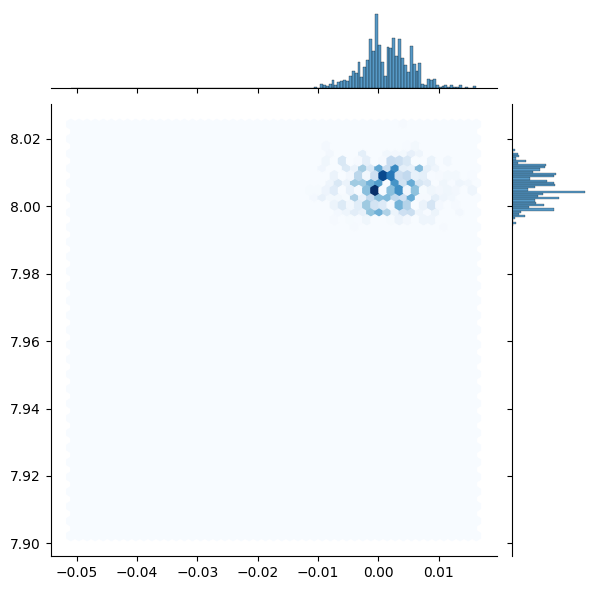

In [71]:
plot_samples = create_sample(samples, 100,10)

plt_samples(plot_samples)

## MALA

In [81]:
def mala(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, gradient_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    #Compute initial values
    samples[0] = initial_theta
    lkhd[0] = np.sum(lkhd_function.comp_func(data, initial_theta))
    grad[0] = np.sum(lkhd_function.comp_grad(data, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize, grad[i], gradient_scaler)

        # Compute the acceptance probability
        lkhd_proposal = np.sum(lkhd_function.comp_func(data, proposal))
        grad_proposal = np.sum(lkhd_function.comp_grad(data, proposal))
        diff_old = npl.norm(npl.norm(proposal - samples[i] + gradient_scaler*grad[i]))
        diff_new = npl.norm(npl.norm(samples[i] - proposal + gradient_scaler*grad_proposal))
        lkhd_diff = lkhd_proposal - lkhd[i]
        acceptence_prob[i] = np.exp(lkhd_diff + (diff_old - diff_new) / (2*stepsize))

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd


In [82]:
# MALA
# Parameters
data = normal_param_data
lkhd = Normal_param_loglkhd()
proposal = Langevin_Sampler()
initial_theta = np.array([2,4])
num_iterations = 10**4
stepsize = 0.1
gradient_scaler = 0.5

samples, accepted, acceptence_prob, lkhd = mala(data, lkhd, proposal, initial_theta, num_iterations, stepsize, gradient_scaler)

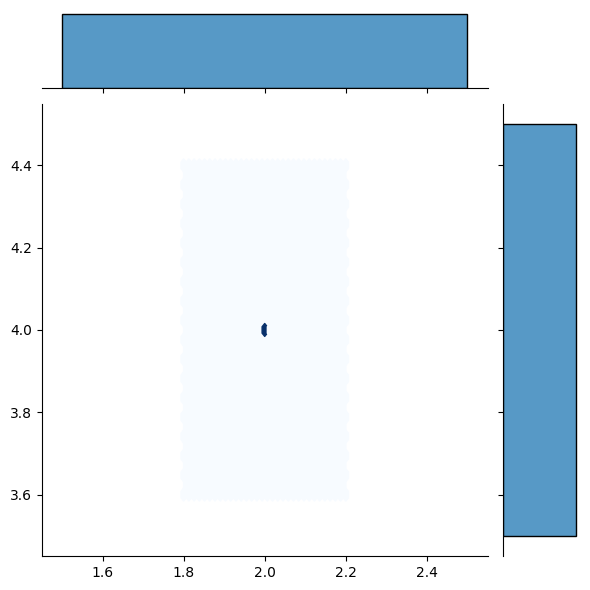

In [83]:
plot_samples = create_sample(samples, 100,10)

plt_samples(plot_samples)